import & device 설정

In [1]:
import os
import torch
from peft import PeftModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

os.makedirs("results", exist_ok=True)

Device: mps


SST-2 로드 + Data split

In [2]:
# SST-2 원본 로드
raw = load_dataset("glue", "sst2")
train_df = raw["train"].to_pandas()

# 8 : 1 : 1 split (train 기준)
train_split, temp_split = train_test_split(train_df, test_size=0.2, random_state=42)
val_split, test_split   = train_test_split(temp_split, test_size=0.5, random_state=42)

test_dataset = Dataset.from_pandas(test_split.reset_index(drop=True))
print("Test size:", len(test_dataset))
print(test_dataset[0])

Test size: 6735
{'sentence': 'a first-class road movie that proves you can run away from home , but your ego and ', 'label': 1, 'idx': 52093}


토크나이저 & test DataLoader

In [3]:
# 공통 BERT 토크나이저
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def encode_batch(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

test_encoded = test_dataset.map(encode_batch, batched=True)
test_encoded = test_encoded.rename_column("label", "labels")
test_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

test_loader = DataLoader(test_encoded, batch_size=64, shuffle=False)

# 문장 리스트 (CSV에 같이 넣을 용도)
test_sentences = test_dataset["sentence"]

/opt/anaconda3/envs/bert-project/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

평가 함수

In [4]:
def evaluate_and_collect(model, data_loader, sentences):
    """
    model: 로드된 분류 모델
    data_loader: test_loader (shuffle=False)
    sentences: test_dataset["sentence"] 리스트
    """
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds  = logits.argmax(-1)

            all_labels.extend(batch["labels"].cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    # 지표 계산
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)

    print(f"Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")

    # 예측 결과 CSV로 저장
    rows = []
    for s, g, p in zip(sentences, all_labels, all_preds):
        rows.append({
            "sentence": s,
            "gold": int(g),
            "pred": int(p),
        })

    return rows

테스트할 모델 목록

In [5]:
models_to_test = [
    {"id": "freeze",   "name": "Freeze FT",      "path": "joononeyyy/bert-sst2-freeze",   "kind": "plain"},
    {"id": "full",     "name": "Full Fine-tune", "path": "joononeyyy/bert-sst2-full",     "kind": "plain"},
    {"id": "partial",  "name": "Partial FT",     "path": "joononeyyy/bert-sst2-partial",  "kind": "plain"},
    {"id": "bitfit",   "name": "BitFit",         "path": "joononeyyy/bert-sst2-bitfit",   "kind": "plain"},
    {"id": "lora",     "name": "LoRA",           "path": "joononeyyy/bert-sst2-lora",     "kind": "lora"},
]

In [6]:
def load_model_from_hf(m):
    """plain 모델과 LoRA(PEFT) 모델을 구분해서 로드"""
    if m["kind"] == "plain":
        model = AutoModelForSequenceClassification.from_pretrained(m["path"])
    elif m["kind"] == "lora":
        # LoRA는 어댑터만 있으므로, 동일한 구조의 base BERT 분류기를 먼저 불러온 뒤 어댑터를 얹는다.
        base_model = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=2,
        )
        model = PeftModel.from_pretrained(base_model, m["path"])
    else:
        raise ValueError(f"Unknown model kind: {m['kind']}")
    return model.to(device).eval()

summary = []

for m in models_to_test:
    print(f"\n🔍 Testing model: {m['name']} ({m['id']})")

    # 1) 모델 로드
    model = load_model_from_hf(m)

    # 2) 평가 + 출력 수집
    rows = evaluate_and_collect(model, test_loader, test_sentences)

    # 3) CSV 저장 (sentence, gold, pred만)
    df_out = pd.DataFrame(rows, columns=["sentence", "gold", "pred"])
    csv_path = f"../results/{m['id']}_test_outputs.csv"
    df_out.to_csv(csv_path, index=False, encoding="utf-8")
    print(f"💾 Saved: {csv_path}")

    # 4) 성능 지표 계산
    gold = df_out["gold"]
    pred = df_out["pred"]

    acc  = accuracy_score(gold, pred)
    prec = precision_score(gold, pred, average="macro")
    rec  = recall_score(gold, pred, average="macro")
    f1   = f1_score(gold, pred, average="macro")

    summary.append({
        "Model Name": m["name"],
        "Model ID":   m["id"],
        "Accuracy":   acc,
        "Precision":  prec,
        "Recall":     rec,
        "F1-score":   f1,
    })

# 5) 지표 정리 저장
df_summary = pd.DataFrame(summary)
df_summary_path = "../results/model_summary.csv"
df_summary.to_csv(df_summary_path, index=False, encoding="utf-8")
print(f"\n📊 Summary saved to {df_summary_path}")

df_summary


🔍 Testing model: Freeze FT (freeze)


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 106/106 [00:58<00:00,  1.82it/s]


Acc=0.7408  Prec=0.7159  Rec=0.8927  F1=0.7946
💾 Saved: ../results/freeze_test_outputs.csv

🔍 Testing model: Full Fine-tune (full)


Evaluating: 100%|██████████| 106/106 [00:57<00:00,  1.84it/s]


Acc=0.9538  Prec=0.9583  Rec=0.9596  F1=0.9589
💾 Saved: ../results/full_test_outputs.csv

🔍 Testing model: Partial FT (partial)


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 106/106 [00:58<00:00,  1.82it/s]


Acc=0.9406  Prec=0.9469  Rec=0.9474  F1=0.9471
💾 Saved: ../results/partial_test_outputs.csv

🔍 Testing model: BitFit (bitfit)


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 106/106 [00:58<00:00,  1.81it/s]


Acc=0.9302  Prec=0.9430  Rec=0.9321  F1=0.9375
💾 Saved: ../results/bitfit_test_outputs.csv

🔍 Testing model: LoRA (lora)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 106/106 [01:02<00:00,  1.71it/s]


Acc=0.9131  Prec=0.9271  Rec=0.9175  F1=0.9223
💾 Saved: ../results/lora_test_outputs.csv

📊 Summary saved to ../results/model_summary.csv


,Model Name,Model ID,Accuracy,Precision,Recall,F1-score
0,Freeze FT,freeze,0.740757,0.757366,0.719374,0.721640
1,Full Fine-tune,full,0.953823,0.953186,0.953016,0.953101
2,Partial FT,partial,0.940609,0.939719,0.939653,0.939686
3,BitFit,bitfit,0.930215,0.928626,0.929955,0.929249
4,LoRA,lora,0.913140,0.911385,0.912523,0.911922


**Model Test**

F1-Score

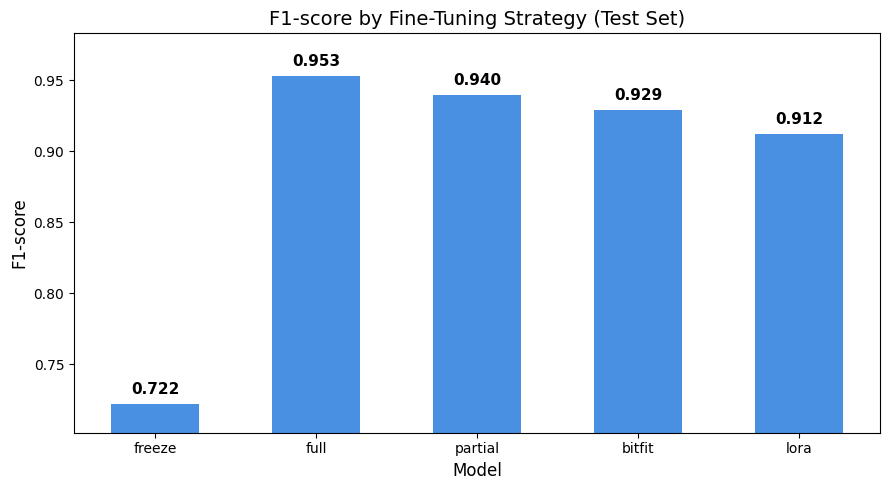

In [ ]:
import matplotlib.pyplot as plt

models = df_summary["Model ID"]
f1s = df_summary["F1-score"]

plt.figure(figsize=(9, 5))

plt.bar(models, f1s, color="#4A90E2", width=0.55)

plt.xlabel("Model", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.title("F1-score by Fine-Tuning Strategy (Test Set)", fontsize=14)

for x, v in zip(models, f1s):
    plt.text(
        x, 
        v + 0.005, 
        f"{v:.3f}", 
        ha="center", 
        va="bottom",
        fontsize=11,
        fontweight="bold"
    ) 

plt.ylim(min(f1s) - 0.02, max(f1s) + 0.03)
plt.tight_layout()
plt.show()

Acc

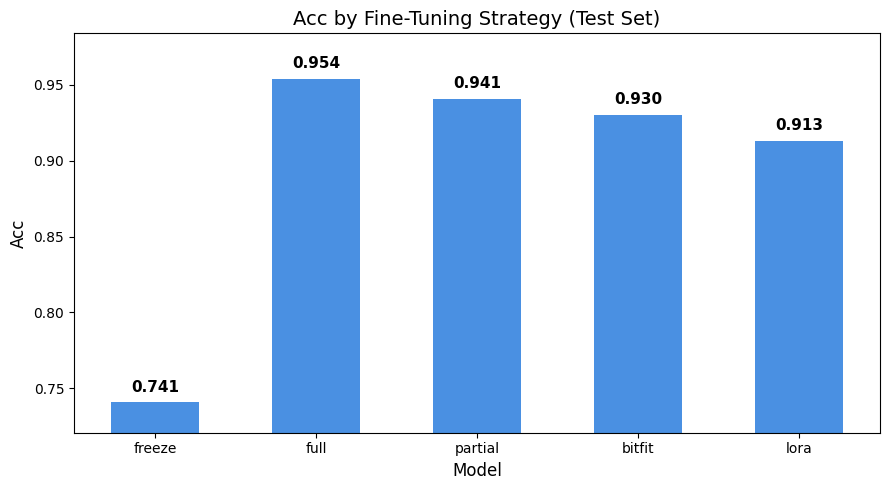

In [ ]:

models = df_summary["Model ID"]
f1s = df_summary["Accuracy"]

plt.figure(figsize=(9, 5))

plt.bar(models, f1s, color="#4A90E2", width=0.55)

plt.xlabel("Model", fontsize=12)
plt.ylabel("Acc", fontsize=12)
plt.title("Acc by Fine-Tuning Strategy (Test Set)", fontsize=14)

for x, v in zip(models, f1s):
    plt.text(
        x, 
        v + 0.005, 
        f"{v:.3f}", 
        ha="center", 
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.ylim(min(f1s) - 0.02, max(f1s) + 0.03)
plt.tight_layout()
plt.show()